In [35]:
learn = pd.read_parquet("../notebooks/data/learn.parquet")
test  = pd.read_parquet("../notebooks/data/test.parquet")
learn.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM,fold
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,1
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,4
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,2,6,2,6,50,3.988984,4
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3


In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, statsmodels.api as sm

FIGDIR = "../figures"

# 1) Policy-Frames laden
learn = pd.read_parquet("../notebooks/data/learn.parquet")
test  = pd.read_parquet("../notebooks/data/test.parquet")

# 2) Frequenzrate laden und an test ausrichten (per IDpol falls vorhanden)
freq_df = pd.read_parquet("../notebooks/data/test_freq_rate.parquet")
if {"IDpol", "freq_rate"}.issubset(freq_df.columns):
    assert test["IDpol"].is_unique, "Duplikate in test['IDpol']"
    freq_pred_test = test["IDpol"].map(freq_df.set_index("IDpol")["freq_rate"]).to_numpy()
else:
    freq_pred_test = freq_df.squeeze().to_numpy()

# 3) Severity (claim-level) laden + säubern
sev = pd.read_parquet("../data/work/freMTPL2sev_clean.parquet")
sev["ClaimAmount"] = pd.to_numeric(sev["ClaimAmount"], errors="coerce")
sev = sev.loc[sev["ClaimAmount"].gt(0) & np.isfinite(sev["ClaimAmount"]), ["IDpol","ClaimAmount"]]

# 4) Grundchecks
assert "IDpol" in learn and "IDpol" in test and "IDpol" in sev, "IDpol fehlt in learn/test/sev"
assert len(freq_pred_test) == len(test), "Längenmismatch: freq_pred_test vs. test"
assert np.isfinite(freq_pred_test).all(), "freq_pred_test enthält NaN/Inf"

print("learn/test shapes:", learn.shape, test.shape)
print("freq_pred_test:", freq_pred_test.shape, "sev:", sev.shape)


learn/test shapes: (542741, 19) (135272, 19)
freq_pred_test: (135272,) sev: (26639, 2)


# Frequenzrate laden – wenn IDpol-Spalte vorhanden: per Join ausrichten
freq_df = pd.read_parquet("../notebooks/data/test_freq_rate.parquet")
if "IDpol" in freq_df.columns and "freq_rate" in freq_df.columns:
    assert test["IDpol"].is_unique, "Duplikate in test['IDpol']"
    freq_pred_test = test["IDpol"].map(freq_df.set_index("IDpol")["freq_rate"]).to_numpy()
else:
    # Reihenfolge = Test-Reihenfolge 
    freq_pred_test = freq_df.squeeze().to_numpy()

# Severity sanity check
sev = pd.read_parquet("../data/work/freMTPL2sev_clean.parquet")
sev["ClaimAmount"] = pd.to_numeric(sev["ClaimAmount"], errors="coerce")
sev = sev.loc[sev["ClaimAmount"].gt(0) & np.isfinite(sev["ClaimAmount"]), ["IDpol", "ClaimAmount"]]

# Basiskontrollen
assert np.isfinite(freq_pred_test).all(), "freq_pred_test enthält NaN/Inf"
print("learn/test shapes:", learn.shape, test.shape)
print("freq_pred_test:", freq_pred_test.shape, "sev:", sev.shape)


In [39]:
learn.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM,fold
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,1
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,4
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,2,6,2,6,50,3.988984,4
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3


In [40]:
# nutze ALLE verfügbaren Policy-Features außer IDpol/Exposure.
feature_cols = [c for c in learn.columns if c not in ["IDpol", "Exposure"]]


# Policy-Features für beide Splits zusammenführen
pol_features = pd.concat(
    [learn[["IDpol"] + feature_cols], test[["IDpol"] + feature_cols]],
    axis=0, ignore_index=True
).drop_duplicates("IDpol")

# Severity (claim-level) mit Policy-Features verheiraten (m:1 Join)
sev_feat = sev.merge(pol_features, on="IDpol", how="left", validate="m:1")
missing = sev_feat[feature_cols].isna().any(axis=1).mean()
print(f"Anteil Zeilen mit fehlenden Features: {missing:.2%}")

Anteil Zeilen mit fehlenden Features: 0.73%


In [41]:
# 1) Diagnose: welche IDs fehlen?
sev_ids = set(sev["IDpol"])
pol_ids = set(pol_features["IDpol"])
missing_ids = sev_ids - pol_ids
print(f"Unmatched claim IDs: {len(missing_ids)} ({len(missing_ids)/len(sev_ids):.2%})")

# 2) Entschiedene Behandlung: <1% -> droppen (sauberste Variante)
before = len(sev_feat)
sev_feat = sev_feat.dropna(subset=feature_cols).copy()
after = len(sev_feat)
print(f"Dropped {before - after} claim rows with missing features "
      f"({(before-after)/before:.2%}). Remaining: {after}")

Unmatched claim IDs: 6 (0.02%)
Dropped 195 claim rows with missing features (0.73%). Remaining: 26444


In [44]:
pearson_chi2 = sum(model_sev.resid_pearson**2)
dispersion = pearson_chi2 / model_sev.df_resid
print(f"Dispersion: {dispersion:.2f}")


Dispersion: 1.00


In [45]:
# Kategoriale vs. numerische bestimmen 
cat_cols = [c for c in feature_cols if sev_feat[c].dtype.name in ("object","category")]
num_cols = [c for c in feature_cols if c not in cat_cols]

# Dummy-Matrix 
X_cat = pd.get_dummies(sev_feat[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=sev_feat.index)
X_num = sev_feat[num_cols].apply(pd.to_numeric, errors="coerce") if num_cols else pd.DataFrame(index=sev_feat.index)

X_sev = pd.concat([X_num, X_cat], axis=1).fillna(0.0)
y_sev = sev_feat["ClaimAmount"].astype(float).to_numpy()

# Intercept
X_sev_sm = sm.add_constant(X_sev, has_constant="add")
print("Design:", X_sev_sm.shape, "Targets:", y_sev.shape)


Design: (26444, 56) Targets: (26444,)


In [46]:
# --- bool -> float konvertieren ---
bool_cols = X_sev_sm.select_dtypes(bool).columns
if len(bool_cols):
    X_sev_sm[bool_cols] = X_sev_sm[bool_cols].astype(float)
    print(f"{len(bool_cols)} bool-Spalten in float konvertiert:", list(bool_cols))

44 bool-Spalten in float konvertiert: ['VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'VehGas_Regular', 'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'Region_Alsace', 'Region_Aquitaine', 'Region_Auvergne', 'Region_Basse-Normandie', 'Region_Bourgogne', 'Region_Bretagne', 'Region_Champagne-Ardenne', 'Region_Corse', 'Region_Franche-Comte', 'Region_Haute-Normandie', 'Region_Ile-de-France', 'Region_Languedoc-Roussillon', 'Region_Limousin', 'Region_Midi-Pyrenees', 'Region_Nord-Pas-de-Calais', 'Region_Pays-de-la-Loire', 'Region_Picardie', 'Region_Poitou-Charentes', "Region_Provence-Alpes-Cotes-D'Azur", 'Region_Rhone-Alpes', 'VehAgeGLM_1', 'VehAgeGLM_3', 'DrivAgeGLM_1', 'DrivAgeGLM_2', 'DrivAgeGLM_3', 'DrivAgeGLM_4', 'DrivAgeGLM_6', 'DrivAgeGLM_7']


In [ ]:
# Claim-level
model_sev = sm.OLS(np.log1p(y_sev), X_sev_sm).fit()
print(model_sev.summary().tables[1])

                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  6.1131      0.109     55.967      0.000       5.899       6.327
VehPower                              -0.0079      0.011     -0.720      0.472      -0.029       0.014
VehAge                                -0.0043      0.002     -1.722      0.085      -0.009       0.001
DrivAge                                0.0032      0.002      1.775      0.076      -0.000       0.007
BonusMalus                            -0.0112      0.007     -1.558      0.119      -0.025       0.003
Density                             -2.86e-06   5.42e-06     -0.528      0.598   -1.35e-05    7.76e-06
ClaimNb                                0.0348      0.019      1.875      0.061      -0.002       0.071
AreaGLM                                0.0808      0.022      3.620      

/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [48]:
pearson_chi2 = sum(model_sev.resid_pearson**2)
dispersion = pearson_chi2 / model_sev.df_resid
print(f"Dispersion: {dispersion:.2f}")


Dispersion: 1.00


In [63]:
# Nach dem OLS-Fit auf y_log = log1p(ClaimAmount):
eta   = model_sev.predict(X_sev_sm)              # log(1+E[y|x]) approximiert
resid = y_log - eta
s     = float(np.exp(resid).mean())              # Duan-Smearing-Faktor

sev_pred_claim = np.exp(eta) * s - 1.0           # zurück auf €-Skala, erwartungsrichtig
sev_pred_claim = np.clip(sev_pred_claim, 0.0, None)

print("Pred ClaimAmount mean:", sev_pred_claim.mean())


Pred ClaimAmount mean: 2249.9066930831386


In [64]:
# Claim -> Policy: Mittel der claim-level Predictions
sev_policy_mean = (
    pd.DataFrame({"IDpol": sev_feat["IDpol"].to_numpy(), "pred": sev_pred_claim})
    .groupby("IDpol", as_index=True)["pred"].mean()
)

print("Policy-level E[X] (mean over policies with claims):", sev_policy_mean.mean())

# Mapping auf TEST; wie viele Policen ohne Claims?
mapped = test["IDpol"].map(sev_policy_mean)
n_missing = mapped.isna().sum()
print("Missing policies (no claims):", n_missing)

global_avg_sev = float(sev_policy_mean.mean())
E_X_test = mapped.fillna(global_avg_sev).to_numpy()

print("E[X] (Test) mean after mapping:", E_X_test.mean())


Policy-level E[X] (mean over policies with claims): 2236.900936734648
Missing policies (no claims): 130291
E[X] (Test) mean after mapping: 2237.1055545129416


In [58]:
PP_test = freq_pred_test * E_X_test
print("PP mean:", PP_test.mean())

PP mean: 87.2916213747201


In [65]:
test["E_X"] = E_X_test
test["PP"] = PP_test

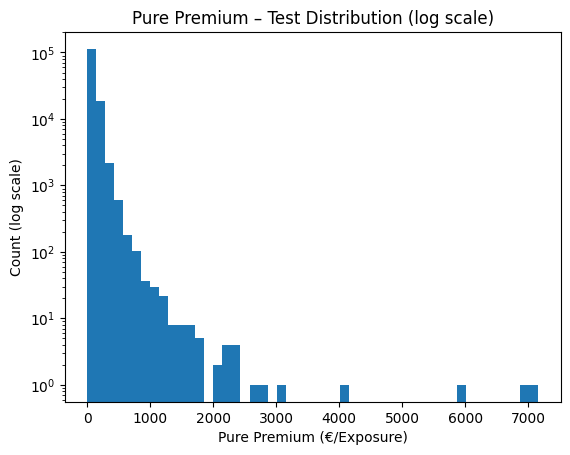

In [89]:
plt.hist(test["PP"], bins=50, log=True)
plt.xlabel("Pure Premium (€/Exposure)")
plt.ylabel("Count (log scale)")
plt.title("Pure Premium – Test Distribution (log scale)")
plt.savefig(os.path.join(FIGDIR, f"pure_premium_hist_log_scale.png"),
                    dpi=150, bbox_inches="tight")
plt.show()

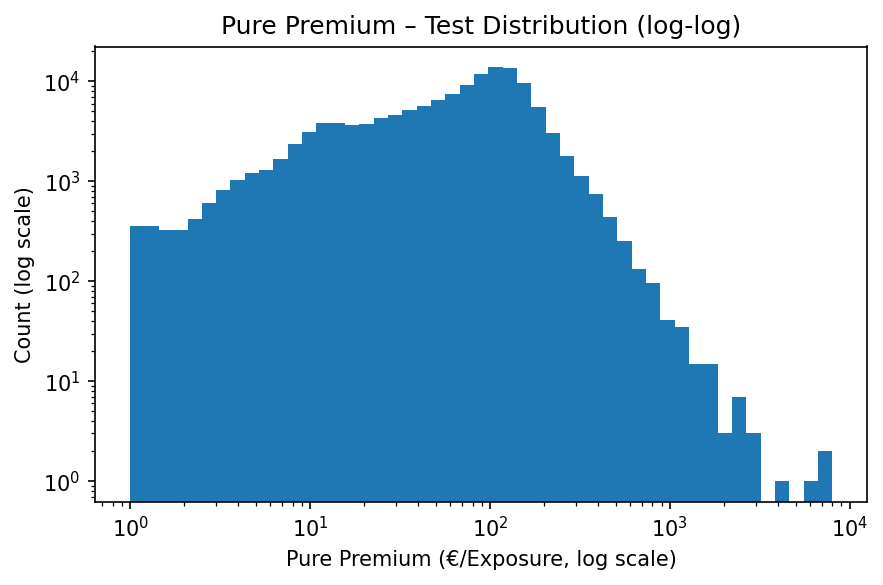

In [79]:
plt.figure(figsize=(6,4), dpi=150)
plt.hist(test["PP"], bins=np.logspace(0, np.log10(8000), 50))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Pure Premium (€/Exposure, log scale)")
plt.ylabel("Count (log scale)")
plt.title("Pure Premium – Test Distribution (log-log)")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, f"pure_premium_hist_log_log_scale.png"),
                    dpi=150, bbox_inches="tight")
plt.show()


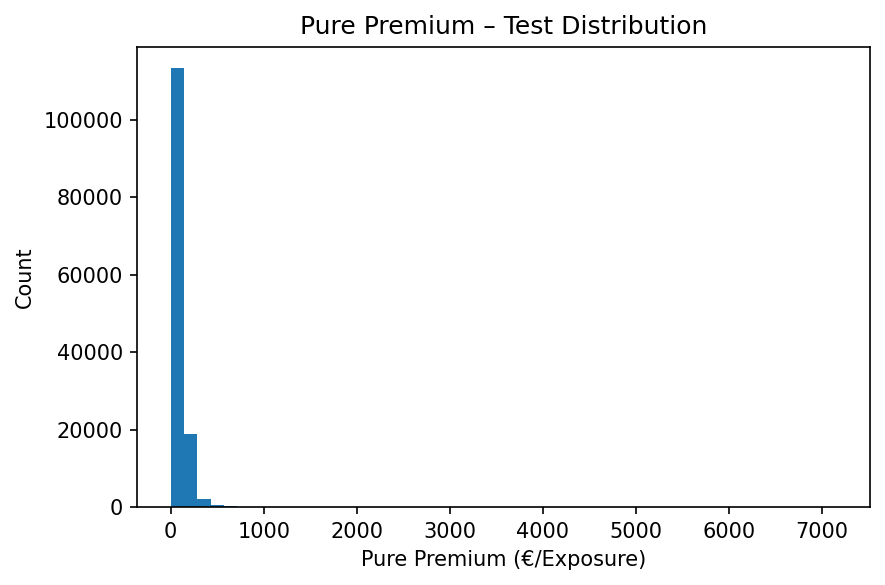

In [69]:
plt.figure(figsize=(6,4), dpi=150)
plt.hist(test["PP"], bins=50)
plt.xlabel("Pure Premium (€/Exposure)")
plt.ylabel("Count")
plt.title("Pure Premium – Test Distribution")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, f"pure_premium_hist.png"),
                    dpi=150, bbox_inches="tight")
plt.show()

In [74]:
#sanity check
y_sev = sev_feat["ClaimAmount"].astype(float).to_numpy()
print("Actual ClaimAmount mean/median:", y_sev.mean(), np.median(y_sev))

Actual ClaimAmount mean/median: 2265.5126493722582 1172.0


In [59]:
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pp_vs_feature(test_df, candidates=("DrivAge","DrivAgeGLM","DriverAge","DrivAgeBinMid"),
                       figdir="../figures"):
    os.makedirs(figdir, exist_ok=True)
    # Feature wählen
    feat = next((c for c in candidates if c in test_df.columns), None)
    if feat is None:
        print("Kein geeignetes Feature gefunden – PP-vs-Feature-Plot wird übersprungen.")
        return

    s = test_df[feat]
    # Fall A: numerisch → Deciles + Linienplot
    if pd.api.types.is_numeric_dtype(s):
        q = pd.qcut(s, 10, duplicates="drop")
        g = test_df.groupby(q, observed=True)["PP"].mean().reset_index()
        mids = g[feat].apply(lambda iv: 0.5*(iv.left + iv.right))
        plt.figure(figsize=(6,4), dpi=150)
        plt.plot(mids, g["PP"], marker="o")
        plt.xlabel(f"{feat} (bin mid)")
        plt.ylabel("Pure Premium (€/Exposure)")
        plt.title(f"Pure Premium vs. {feat}")
        plt.tight_layout()
        plt.savefig(os.path.join(figdir, f"pure_premium_vs_{feat.lower()}.png"),
                    dpi=150, bbox_inches="tight")
        plt.show()
        return

    # Fall B: kategorial → Mittel je Kategorie; wenn Intervalle, nach Mitte sortieren
    def _mid(v):
        if pd.api.types.is_interval(v): return 0.5*(v.left+v.right)
        if isinstance(v,str):
            m = re.match(r"[\(\[]\s*([-+]?\d+\.?\d*)\s*,\s*([-+]?\d+\.?\d*)\s*[\)\]]", v)
            if m: return (float(m.group(1))+float(m.group(2)))/2
        return np.nan

    g = test_df.groupby(s.astype("category"), observed=True)["PP"].mean().reset_index()
    mids = g[feat].apply(_mid)
    if mids.notna().all():
        order = np.argsort(mids.values)
        x, y = mids.values[order], g["PP"].values[order]
        plt.figure(figsize=(6,4), dpi=150)
        plt.plot(x, y, marker="o")
        plt.xlabel(f"{feat} (bin mid)")
        plt.ylabel("Pure Premium (€/Exposure)")
        plt.title(f"Pure Premium vs. {feat} (categorical)")
        plt.tight_layout()
        plt.savefig(os.path.join(figdir, f"pure_premium_vs_{feat.lower()}.png"),
                    dpi=150, bbox_inches="tight")
        plt.show()
    else:
        g2 = g.sort_values("PP")
        plt.figure(figsize=(7,4), dpi=150)
        plt.bar(g2[feat].astype(str), g2["PP"])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Pure Premium (€/Exposure)")
        plt.title(f"Pure Premium by {feat}")
        plt.tight_layout()
        plt.savefig(os.path.join(figdir, f"pure_premium_by_{feat.lower()}.png"),
                    dpi=150, bbox_inches="tight")
        plt.show()


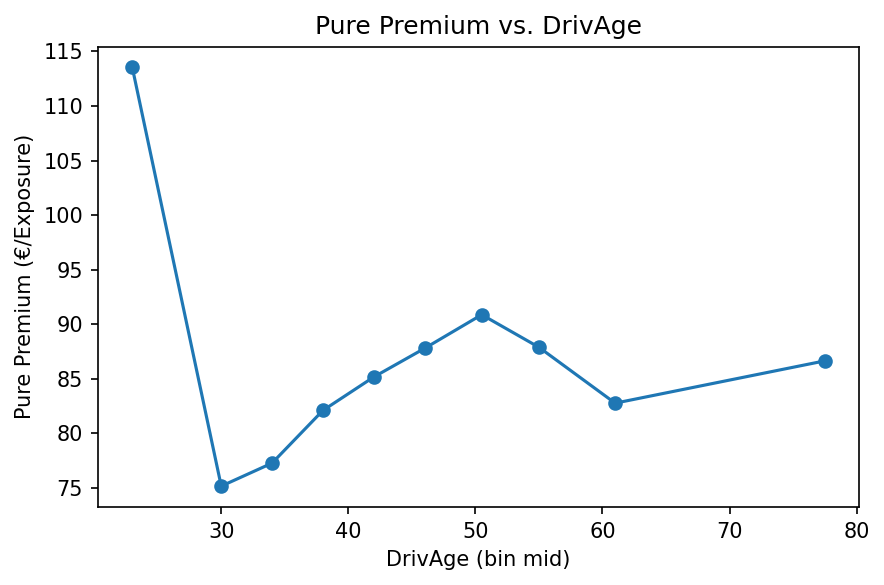

In [67]:
plot_pp_vs_feature(test)

In [73]:
# tatsächlicher Schaden pro Exposure im Test 
if {"ClaimNb","Exposure"}.issubset(test.columns):
    # grobe Erwartungscheck: PP_mean ≈ (Total Claims * avg severity) / Total Exposure
    print("Exposure sum:", test["Exposure"].sum().round(0))
print("E[X] mean:", test["E_X"].mean().round(2),
      "E[N] mean:", freq_pred_test.mean().round(5),
      "PP mean:", test["PP"].mean().round(2))


Exposure sum: 71433.0
E[X] mean: 2237.11 E[N] mean: 0.03885 PP mean: 87.29


## Zusammenfassung – Severity & Pure Premium Results

| Metric | Value |
|:--|--:|
| E[X] (mean claim severity) | **2 237 €** |
| E[N] (mean claim frequency) | **0.0389** |
| Pure Premium (mean per exposure) | **87.3 €** |

- Distribution ist stark rechtsschief, wie erwartet.  
- Junge Fahrer (20–25 J.) zeigen die höchsten erwarteten Prämien (~110 €).  
- Werte und Struktur sind plausibel im Kontext französischer MTPL-Daten.  


In [80]:
# Modellmetriken zusammenfassen
perf = pd.DataFrame([
    {"Model": "GLM1", "PDW": 29.55, "Gini": 0.299, "Calib": 7.38, "PurePremium": np.nan},
    {"Model": "GLM2", "PDW": 29.52, "Gini": 0.301, "Calib": 7.36, "PurePremium": np.nan},
    {"Model": "GAM",  "PDW": 29.16, "Gini": 0.299, "Calib": 7.36, "PurePremium": np.nan},
    {"Model": "Pure Premium", "PDW": np.nan, "Gini": np.nan, "Calib": np.nan, "PurePremium": 87.3},
])

perf

,Model,PDW,Gini,Calib,PurePremium
0,GLM1,29.55,0.299,7.38,NaN
1,GLM2,29.52,0.301,7.36,NaN
2,GAM,29.16,0.299,7.36,NaN
3,Pure Premium,NaN,NaN,NaN,87.3


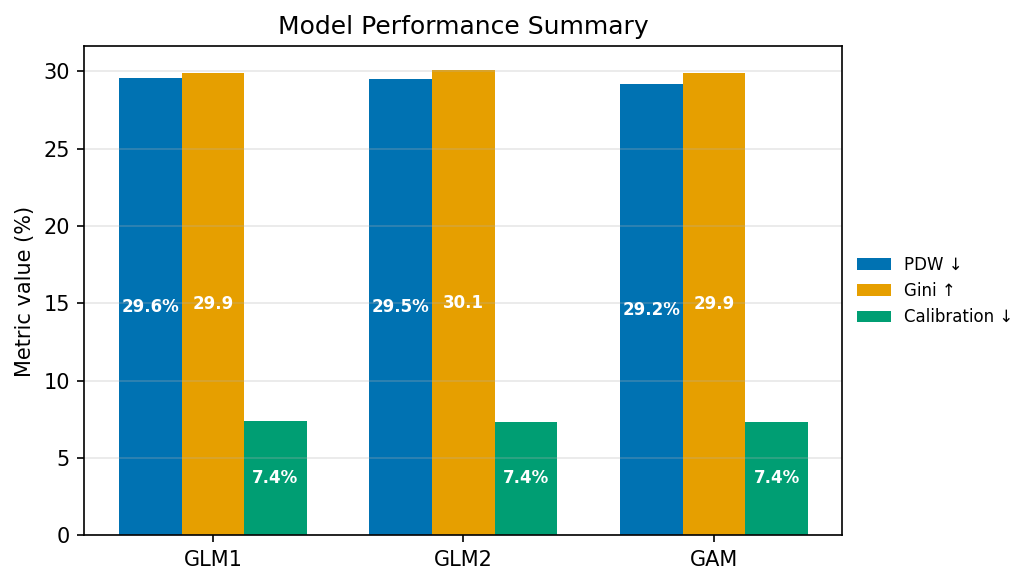

In [87]:
perf = pd.DataFrame([
    {"Model": "GLM1", "PDW": 29.55, "Gini": 0.299, "Calib": 7.38},
    {"Model": "GLM2", "PDW": 29.52, "Gini": 0.301, "Calib": 7.36},
    {"Model": "GAM",  "PDW": 29.16, "Gini": 0.299, "Calib": 7.36},
])

x = np.arange(len(perf))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

# Balken zeichnen
bars_pdw = ax.bar(x - bar_width, perf["PDW"], width=bar_width, label="PDW ↓", color="#0072B2")
bars_gini = ax.bar(x, perf["Gini"] * 100, width=bar_width, label="Gini ↑", color="#E69F00")
bars_calib = ax.bar(x + bar_width, perf["Calib"], width=bar_width, label="Calibration ↓", color="#009E73")

# Hilfsfunktion für Labels im Balken
def annotate_bars(bars, fmt="{:.2f}", suffix="", offset=0.3):
    for b in bars:
        height = b.get_height()
        ax.text(
            b.get_x() + b.get_width()/2,
            height / 2,  # zentriert im Balken
            fmt.format(height) + suffix,
            ha="center", va="center",
            fontsize=8, color="white", fontweight="bold"
        )

# Werte annotieren
annotate_bars(bars_pdw, fmt="{:.1f}", suffix="%")
annotate_bars(bars_gini, fmt="{:.1f}")   # kein Prozentzeichen
annotate_bars(bars_calib, fmt="{:.1f}", suffix="%")

# Achsen & Layout
ax.set_xticks(x)
ax.set_xticklabels(perf["Model"])
ax.set_ylabel("Metric value (%)")
ax.set_title("Model Performance Summary")

ax.grid(axis="y", alpha=0.3)
ax.legend(
    loc="center left", bbox_to_anchor=(1, 0.5),
    frameon=False, fontsize=8
)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "perf_summary_full.png"),
            dpi=150, bbox_inches="tight")
plt.show()


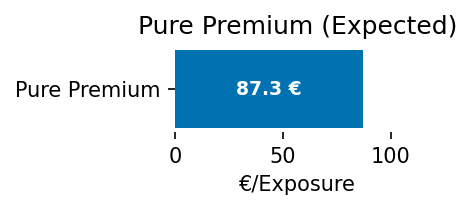

In [84]:
pp = 87.3  
model_name = "Pure Premium"

fig, ax = plt.subplots(figsize=(3, 1.5), dpi=150)
bar = ax.barh([model_name], [pp], color="#0072B2")

# Zahl mittig im Balken
for b in bar:
    width = b.get_width()
    ax.text(
        width / 2, b.get_y() + b.get_height() / 2,
        f"{width:.1f} €",
        ha="center", va="center", color="white", fontsize=9, fontweight="bold"
    )

ax.set_xlim(0, pp * 1.3)
ax.set_xlabel("€/Exposure")
ax.set_title("Pure Premium (Expected)")
ax.spines[:].set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "pure_premium_summary.png"),
            dpi=150, bbox_inches="tight")
plt.show()


/tmp/ipykernel_9505/1925545028.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


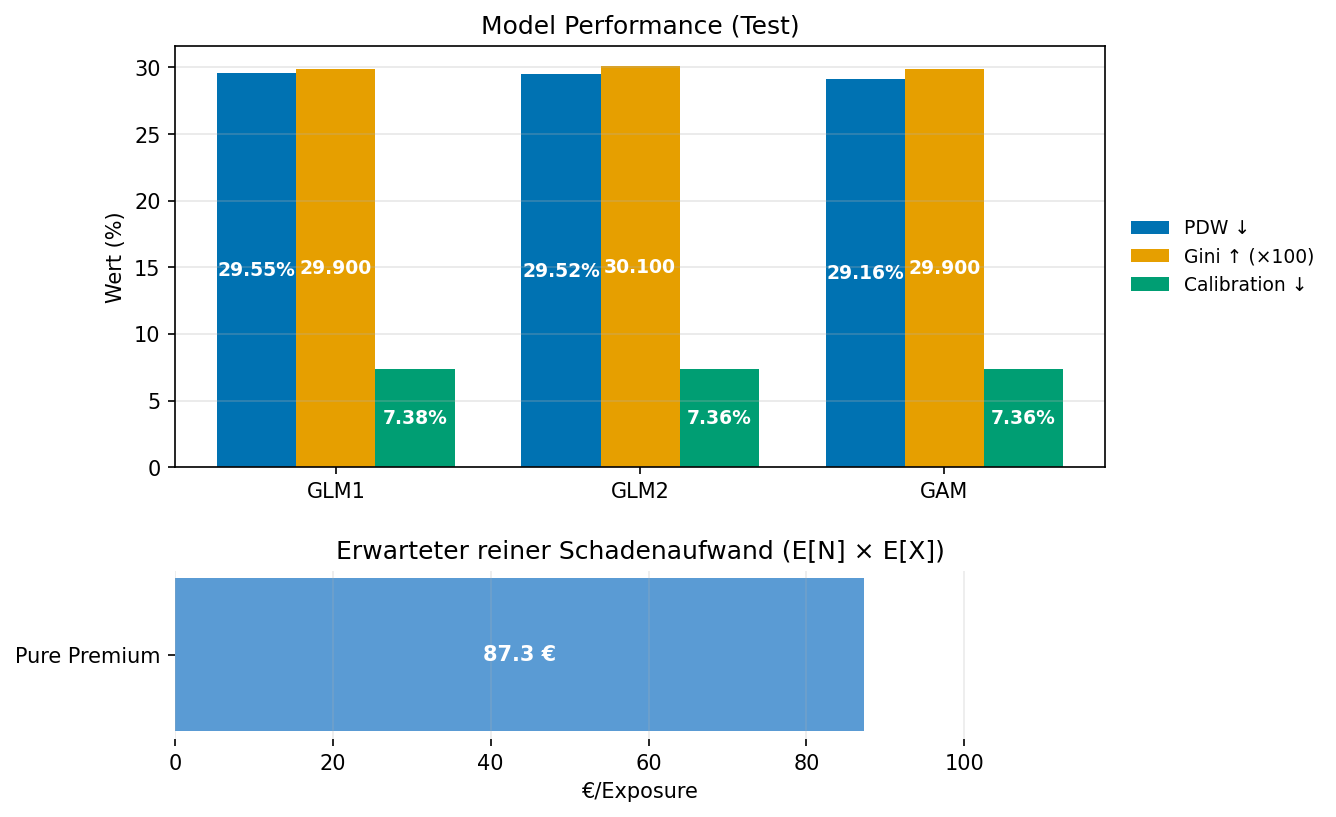

saved: ../figures/perf_dashboard.png


In [88]:

perf = pd.DataFrame([
    {"Model": "GLM1", "PDW": 29.55, "Gini": 0.299, "Calib": 7.38},
    {"Model": "GLM2", "PDW": 29.52, "Gini": 0.301, "Calib": 7.36},
    {"Model": "GAM",  "PDW": 29.16, "Gini": 0.299, "Calib": 7.36},
])
pure_premium_value = 87.3  # €/Exposure

# --- Figure-Layout: oben Metriken, unten Pure Premium ---
fig = plt.figure(figsize=(8, 6), dpi=150)
gs  = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3, 1.2], hspace=0.35)

# --- (A) Balkengruppen: PDW/Gini/Calibration ---
ax = fig.add_subplot(gs[0, 0])
x = np.arange(len(perf)); bw = 0.26
bars_pdw   = ax.bar(x - bw, perf["PDW"],          width=bw, label="PDW ↓",         color="#0072B2")
bars_gini  = ax.bar(x,      perf["Gini"] * 100.0, width=bw, label="Gini ↑ (×100)", color="#E69F00")
bars_calib = ax.bar(x + bw, perf["Calib"],        width=bw, label="Calibration ↓", color="#009E73")

def annotate(bars, fmt="{:.2f}", suffix=""):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x()+b.get_width()/2, h/2, fmt.format(h)+suffix,
                ha="center", va="center", color="white", fontsize=9, fontweight="bold")

annotate(bars_pdw,   "{:.2f}", "%")
annotate(bars_gini,  "{:.3f}", "")
annotate(bars_calib, "{:.2f}", "%")

ax.set_xticks(x); ax.set_xticklabels(perf["Model"])
ax.set_ylabel("Wert (%)")
ax.set_title("Model Performance (Test)")
ax.grid(axis="y", alpha=0.3)
ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize=9)

# --- (B) Pure Premium-Balken unten ---
ax2 = fig.add_subplot(gs[1, 0])
bar = ax2.barh(["Pure Premium"], [pure_premium_value], color="#5A9BD4")
w = bar[0].get_width()
ax2.text(w/2, bar[0].get_y()+bar[0].get_height()/2, f"{w:.1f} €",
         ha="center", va="center", color="white", fontsize=10, fontweight="bold")
ax2.set_xlim(0, pure_premium_value*1.35)
ax2.set_xlabel("€/Exposure")
ax2.set_title("Erwarteter reiner Schadenaufwand (E[N] × E[X])")
for spine in ["top","right","left","bottom"]: ax2.spines[spine].set_visible(False)
ax2.grid(axis="x", alpha=0.25)

plt.tight_layout()
out = os.path.join(FIGDIR, "perf_dashboard.png")
plt.savefig(out, dpi=150, bbox_inches="tight")
plt.show()
print("saved:", out)
